# Lab 5: time series forecast with AutoGluon

[AutoGluon](https://auto.gluon.ai/stable/index.html) is an open-source AutoML library that automates machine learning and deep learning for applications involving image, text, and tabular data. It enables users to quickly develop high-performance models with just a few lines of code by automating tasks like data preprocessing, model selection, hyperparameter tuning, and ensemble learning.

[AutoGluon Time Series](https://auto.gluon.ai/stable/tutorials/timeseries/index.html) can forecast the future values of multiple time series given the historical data and other related covariates. A single call to AutoGluon [`TimeSeriesPredictor`](https://auto.gluon.ai/stable/api/autogluon.timeseries.TimeSeriesPredictor.html)’s `fit()` method trains multiple models to generate accurate probabilistic forecasts, and does not require you to manually deal with cumbersome issues like model selection and hyperparameter tuning.

Under the hood, AutoGluon combines various state of the art forecasting algorithms. These include established statical methods like ETS and ARIMA from [`StatsForecast`](https://github.com/Nixtla/statsforecast), efficient tree-based forecasters like LightGBM based on [AutoGluon-Tabular](https://auto.gluon.ai/stable/tutorials/tabular/index.html), flexible deep learning models like [DeepAR](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html) and Temporal Fusion Transformer from [GluonTS](https://ts.gluon.ai/), and a pretrained zero-shot forecasting model, [Chronos](https://github.com/amazon-science/chronos-forecasting). 

This workshop features DeepAR algorithm in the notebook [lab 3](./lab3_sagemaker_deepar.ipynb) and Chronos in the notebook [lab 4](./lab4_chronos.ipynb).

AutoGluon Time Series provides a robust and easy way to use Chronos through the `TimeSeriesPredictor` API. More specifically:
- Chronos can be combined with other forecasting models to build accurate ensembles using the `high_quality` and `best_quality` presets.
- Alternatively, Chronos can be used as a standalone zero-shot model with presets such as `"chronos_small"` or `"chronos_base"`.

For the full list of available time series algorithm used in AutoGluon refer to the [Model Zoo](https://auto.gluon.ai/stable/tutorials/timeseries/forecasting-model-zoo.html) page in the AutoGluon documentation.

This notebook demonstrate how to build time series forecast using AutoGluon Time Series API.

If you're not familiar with time series forecast, refer to [Forecasting Time Series in Depth](https://auto.gluon.ai/stable/tutorials/timeseries/forecasting-indepth.html) section in the AutoGluon documentation for more details and background.

## Import packages

In [ ]:
!rm -rf /opt/conda/lib/python3.10/site-packages/fsspec*
%pip install fsspec

In [ ]:
%pip install --upgrade autogluon
# %pip uninstall -q torchaudio torchvision torchtext # fix incompatible package versions on Colab
%pip install --upgrade pip sagemaker boto3 s3fs

In [184]:
%matplotlib inline

import json
import os
import boto3
import zipfile
from time import gmtime, strftime, sleep
import datetime
import sagemaker
import numpy as np
import pandas as pd
import tqdm
import torch
import autogluon
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import ipywidgets as widgets
from ipywidgets import (
interact, interactive, fixed, interact_manual,
IntSlider, FloatSlider, Checkbox, Dropdown, DatePicker, SelectMultiple
)

from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
from autogluon.timeseries.splitter import ExpandingWindowSplitter

In [185]:
from importlib.metadata import version
print(version('autogluon'))

1.1.1


## Set literals and general variables

In [186]:
%store -r
%store

try:
    domain_id
except NameError:
    print("""\033[91m 
    **************************************************************************************
    domain_id is not defined!
    Set it manually or run the "Setup notebook environment" section of the lab 1 notebook
    **************************************************************************************
    \033[0m""")

Stored variables and their in-db values:
domain_id                     -> 'd-bxyhco2o9dpc'
region                        -> 'us-east-1'
space_name                    -> 'sagemaker-space'
user_profile_name             -> 'studio-user-ts-0f6b7e60'


In [187]:
sagemaker_session = sagemaker.Session()
region = sagemaker_session.boto_region_name
sm = boto3.client("sagemaker")

In [188]:
s3_bucket = sagemaker_session.default_bucket()  # replace with an existing bucket if needed
s3_prefix = "autogluon-demo-notebook"  # prefix used for all data stored within the bucket
experiment_prefix = "autogluon"

sm_role = sagemaker.get_execution_role()  # IAM role to use by SageMaker

In [189]:
s3_data_path = f"s3://{s3_bucket}/{s3_prefix}/data"
s3_output_path = f"s3://{s3_bucket}/{s3_prefix}/output"

## Download the dataset

Download the from the SageMaker example S3 bucket. You use the [electricity dataset](https://archive.ics.uci.edu/ml/datasets/ElectricityLoadDiagrams20112014) from the repository of the University of California, Irvine:
> Trindade, Artur. (2015). ElectricityLoadDiagrams20112014. UCI Machine Learning Repository. https://doi.org/10.24432/C58C86.

In [190]:
dataset_zip_file_name = "LD2011_2014.txt.zip"
s3_dataset_path = f"datasets/timeseries/uci_electricity/{dataset_zip_file_name}"

In [191]:
os.makedirs("./data", exist_ok=True)

s3_client = boto3.client("s3")
s3_client.download_file(
    f"sagemaker-example-files-prod-{region}", s3_dataset_path, f"./data/{dataset_zip_file_name}"
)

In [192]:
zip_ref = zipfile.ZipFile(f"./data/{dataset_zip_file_name}", "r")
zip_ref.extractall("./data")
zip_ref.close()
dataset_path = '.'.join(zip_ref.filename.split('.')[:-1])

In [193]:
# see what is inside the file
# !head -n 2 {dataset_path} 

## Explore and preprocess data

In [194]:
df_raw = pd.read_csv(
    dataset_path, 
    sep=';', 
    index_col=0,
    decimal=',',
    parse_dates=True,
)

In [195]:
df_raw

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2011-01-01 00:15:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 00:30:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 00:45:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 01:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 01:15:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-31 23:00:00,2.538071,22.048364,1.737619,150.406504,85.365854,303.571429,11.305822,282.828283,68.181818,72.043011,...,276.945039,28200.0,1616.033755,1363.636364,29.986962,5.851375,697.102722,176.961603,651.026393,7621.621622
2014-12-31 23:15:00,2.538071,21.337127,1.737619,166.666667,81.707317,324.404762,11.305822,252.525253,64.685315,72.043011,...,279.800143,28300.0,1569.620253,1340.909091,29.986962,9.947338,671.641791,168.614357,669.354839,6702.702703
2014-12-31 23:30:00,2.538071,20.625889,1.737619,162.601626,82.926829,318.452381,10.175240,242.424242,61.188811,74.193548,...,284.796574,27800.0,1556.962025,1318.181818,27.379400,9.362200,670.763828,153.589316,670.087977,6864.864865
2014-12-31 23:45:00,1.269036,21.337127,1.737619,166.666667,85.365854,285.714286,10.175240,225.589226,64.685315,72.043011,...,246.252677,28000.0,1443.037975,909.090909,26.075619,4.095963,664.618086,146.911519,646.627566,6540.540541


In [196]:
# resample to 2h intervals
freq = "2H"
div = 8 # 2 hours contain 8x 15 min intervals, you need to  delete the resampled value by 8
num_timeseries = df_raw.shape[1]
data_kw = df_raw.resample(freq).sum() / div
timeseries = []

for i in tqdm.trange(num_timeseries):
    timeseries.append(np.trim_zeros(data_kw.iloc[:, i], trim="f"))

100%|██████████| 370/370 [00:00<00:00, 1931.03it/s]


In [197]:
data_kw

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2011-01-01 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 02:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 04:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 06:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 08:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-31 16:00:00,2.379442,28.538407,1.954822,160.569106,67.225610,260.416667,7.560769,352.693603,75.830420,53.897849,...,439.864383,40675.0,2816.983122,3980.113636,127.933507,7.753072,504.938543,118.948247,703.445748,12033.783784
2014-12-31 18:00:00,2.220812,28.449502,2.172024,208.587398,91.310976,385.788690,12.719050,359.427609,95.498252,84.408602,...,425.053533,43300.0,2793.776371,3454.545455,105.606258,5.266238,500.877963,47.787980,706.011730,9554.054054
2014-12-31 20:00:00,2.379442,24.004267,1.737619,174.288618,89.176829,330.357143,11.447145,292.508418,84.134615,75.806452,...,330.389008,39137.5,1676.160338,1857.954545,74.967405,4.169105,420.654083,131.886477,675.219941,8344.594595
2014-12-31 22:00:00,2.062183,21.692745,1.737619,161.331301,85.365854,311.383929,11.023177,251.262626,68.181818,72.446237,...,289.079229,31775.0,1591.244726,1303.977273,46.284224,7.533645,665.605795,178.422371,669.263196,7263.513514


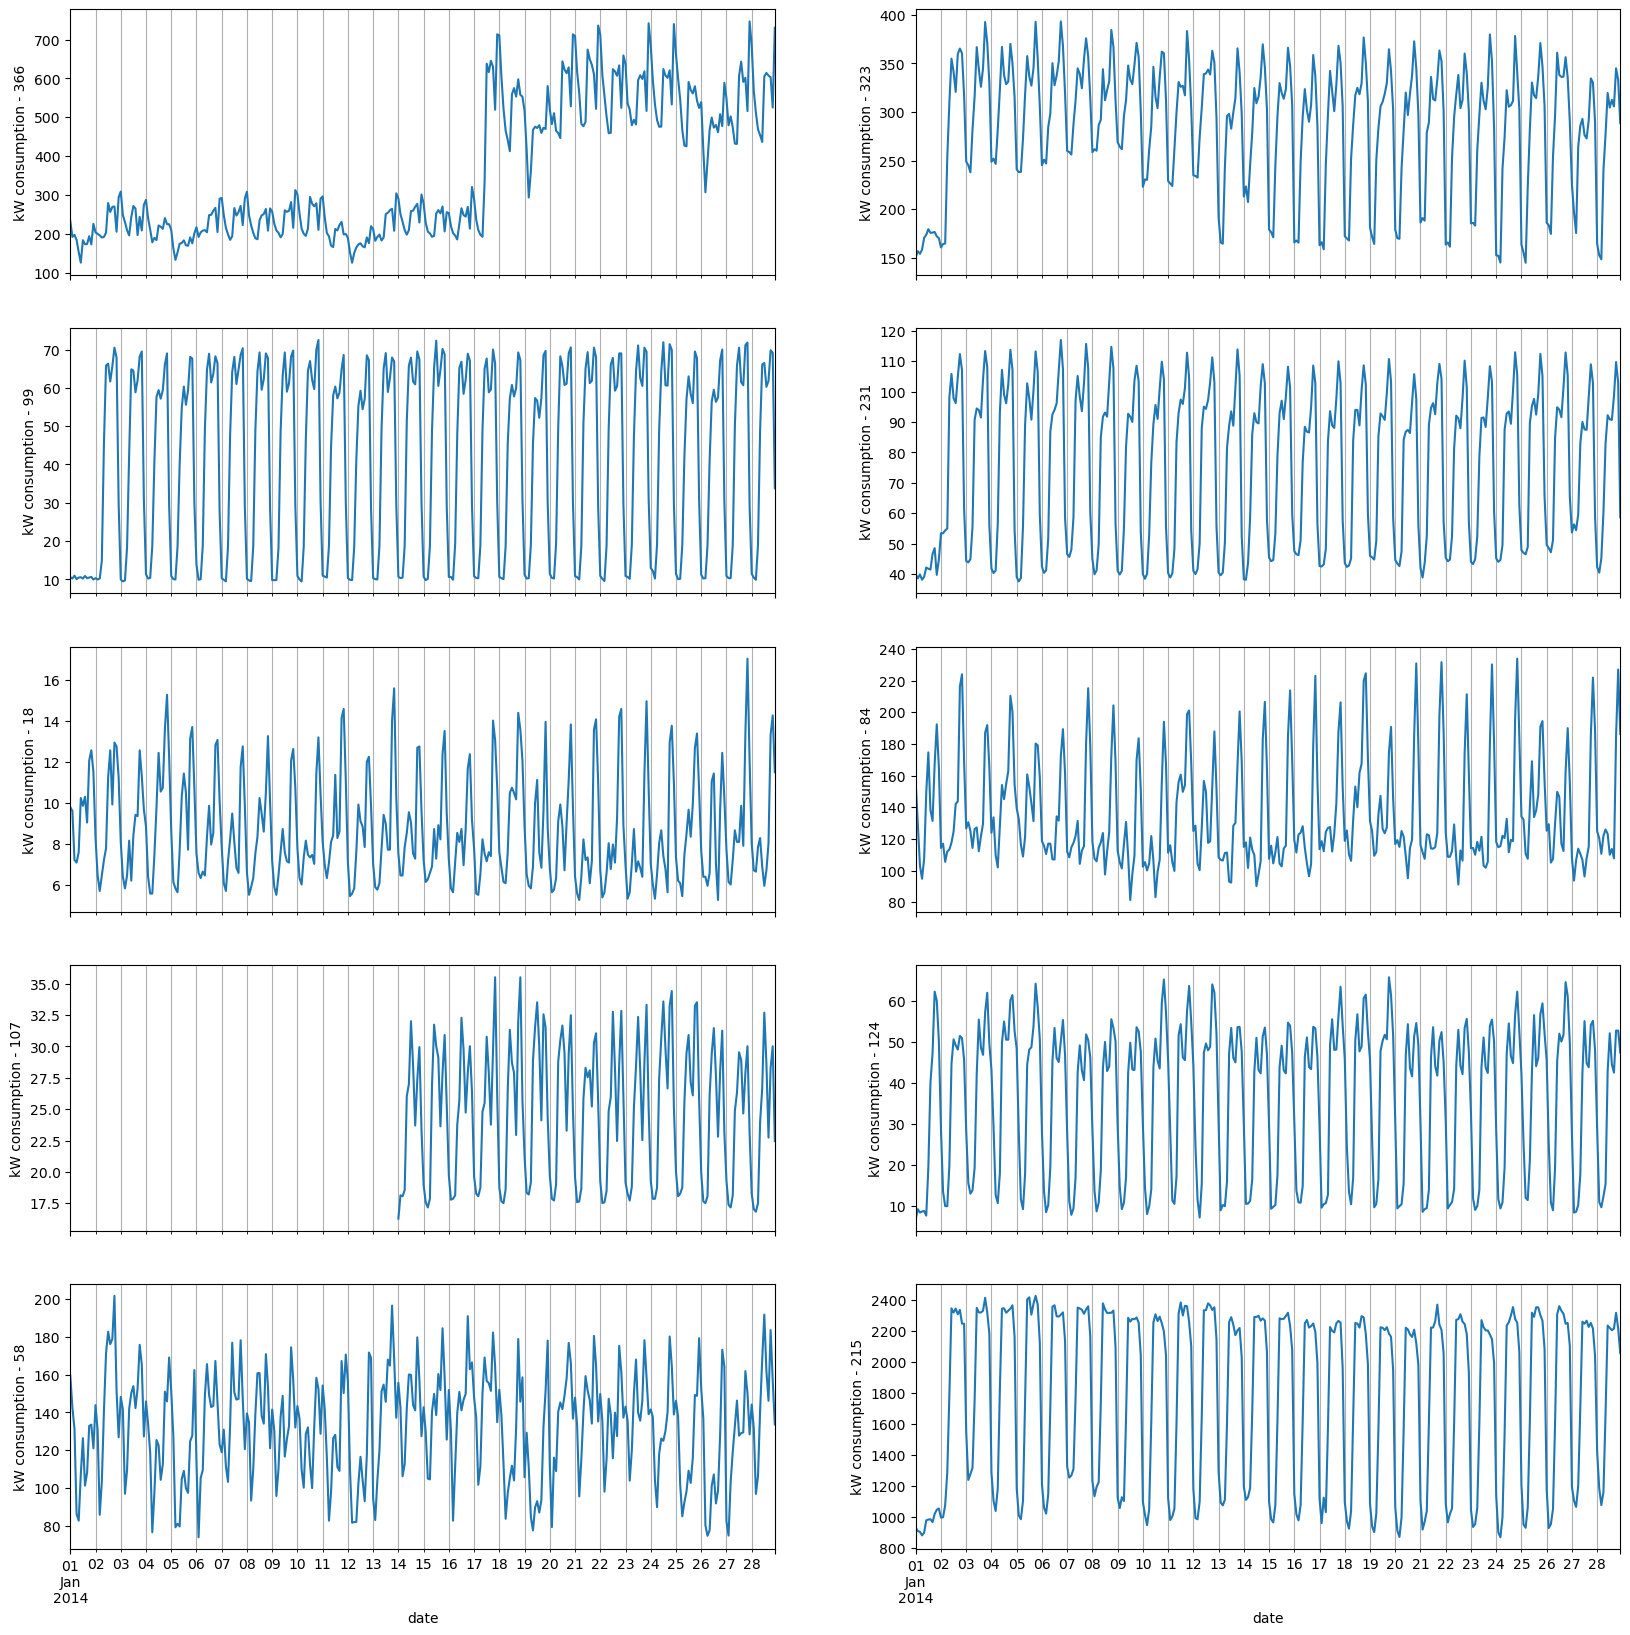

In [198]:
# show random 10 timeseries for 28 day period
fig, axs = plt.subplots(5, 2, figsize=(20, 20), sharex=True)
axx = axs.ravel()
for i, ts_id in enumerate(np.random.randint(1, data_kw.shape[1], size=10).tolist()):
    timeseries[ts_id].loc["2014-01-01":"2014-01-28"].plot(ax=axx[i])
    axx[i].set_xlabel("date")
    axx[i].set_ylabel(f"kW consumption - {ts_id}")
    axx[i].grid(which="minor", axis="x")

Create a smaller dataset with a subset of time series:

In [199]:
# select two random time series to include in a small dataset
size = 2
columns_to_keep = np.random.randint(1, data_kw.shape[1], size=size).tolist()
columns_to_keep

[226, 97]

In [200]:
data_kw_small = data_kw.iloc[:, columns_to_keep]
data_kw_small

,MT_227,MT_098
2011-01-01 00:00:00,177.840328,0.000000
2011-01-01 02:00:00,176.049130,0.000000
2011-01-01 04:00:00,205.603889,0.000000
2011-01-01 06:00:00,210.593654,0.000000
2011-01-01 08:00:00,258.060389,0.000000
...,...,...
2014-12-31 16:00:00,274.437052,1180.189456
2014-12-31 18:00:00,211.489253,646.622735
2014-12-31 20:00:00,108.879222,315.897858
2014-12-31 22:00:00,90.583419,302.718287


## Train AutoGluon models

To start with AutoGluon you need:
1. Convert your time series dataset to a `TimeSeriesDataFrame`
2. Configure AutoGluon `TimeSeriesPredictor`
3. Fit models

This section takes you through these steps and produces a trained predictor.

Refere to the [AutoGluon Time Series - Forecasting Quick Start](https://auto.gluon.ai/stable/tutorials/timeseries/forecasting-quick-start.html) documentation for details on time series forecasting.

In [201]:
# predict for 7 days
prediction_days = 7
intervals_per_day = 12
prediction_length = prediction_days * intervals_per_day

print(f"Sampling frequency set to {freq}. Generate predictions for {prediction_length} intervals")

Sampling frequency set to 2H. Generate predictions for 84 intervals


### Convert dataset to AutoGluon format

AutoGluon expects time series data in [long format](https://doc.dataiku.com/dss/latest/time-series/data-formatting.html#long-format). Each row of the data frame contains a single observation (timestep) of a single time series represented by:
- unique ID of the time series (`"item_id"`) as int or str  
- timestamp of the observation (`"timestamp"`) as a `pandas.Timestamp` or compatible format
- numeric value of the time series (`"target"`)

Note, you can choose the names of the columns arbitrary, but need to specify the names when constructing a `TimeSeriesDataFrame` object.

<div class="alert alert-info">
To reduce the training time you can use a subset of time series instead of the full dataset with 370 time series.
</div>

For AWS-led workshop please choose a small dataset by leaving the `USE_FULL_DATASET` on it's default value `False`. The training time for the small dataset is about 5-12 minutes depending on the used JupyterLab App instance. The train time for the full dataset is about 40-70 minutes depending on the instance type. See the section **Train models** for more data points on training times on different SageMaker instances.

In [202]:
USE_FULL_DATASET = False

In [203]:
if USE_FULL_DATASET:
    ts_wide_df = data_kw
else:
    ts_wide_df = data_kw_small

In [204]:
# Melt the DataFrame
melted_df = pd.melt(
    ts_wide_df.reset_index(),
    id_vars='index', 
    value_vars=ts_wide_df.columns, 
    var_name='item_id', 
    value_name='target'
)

# Rename the 'index' column to 'timestamp'
melted_df = melted_df.rename(columns={'index': 'timestamp'})

print(melted_df)

                timestamp item_id       target
0     2011-01-01 00:00:00  MT_227   177.840328
1     2011-01-01 02:00:00  MT_227   176.049130
2     2011-01-01 04:00:00  MT_227   205.603889
3     2011-01-01 06:00:00  MT_227   210.593654
4     2011-01-01 08:00:00  MT_227   258.060389
...                   ...     ...          ...
35061 2014-12-31 16:00:00  MT_098  1180.189456
35062 2014-12-31 18:00:00  MT_098   646.622735
35063 2014-12-31 20:00:00  MT_098   315.897858
35064 2014-12-31 22:00:00  MT_098   302.718287
35065 2015-01-01 00:00:00  MT_098    31.095552

[35066 rows x 3 columns]


Use the [`TimeSeriesDataFrame`](https://auto.gluon.ai/stable/api/autogluon.timeseries.TimeSeriesDataFrame.html) classs to convert a Pandas DataFrame to AutoGluon time series Data Frame.

In [205]:
ts_df = TimeSeriesDataFrame.from_data_frame(
    melted_df,
    id_column="item_id",
    timestamp_column="timestamp",
)

In [206]:
ts_df

target
item_id timestamp                       
MT_227  2011-01-01 00:00:00   177.840328
        2011-01-01 02:00:00   176.049130
        2011-01-01 04:00:00   205.603889
        2011-01-01 06:00:00   210.593654
        2011-01-01 08:00:00   258.060389
...                                  ...
MT_098  2014-12-31 16:00:00  1180.189456
        2014-12-31 18:00:00   646.622735
        2014-12-31 20:00:00   315.897858
        2014-12-31 22:00:00   302.718287
        2015-01-01 00:00:00    31.095552

[35066 rows x 1 columns]

Note that AutoGluon generates forecasts for each time series individually, without modeling interactions between different items/time series. 

### Split the dataset to train and test
Split the dataset:
- In the `train_df`, the last `prediction_length` time steps are removed from the end of each time series - meaning each time series contains the slice `[:-prediction_length]`
- The `test_df` contains the same data as the original dataset

In [207]:
train_df, test_df = ts_df.train_test_split(prediction_length)

In [208]:
train_df.tail()

target
item_id timestamp                       
MT_098  2014-12-24 16:00:00  1222.817133
        2014-12-24 18:00:00   734.349259
        2014-12-24 20:00:00   286.655684
        2014-12-24 22:00:00   290.156507
        2014-12-25 00:00:00   211.696870

In [209]:
test_df.tail()

target
item_id timestamp                       
MT_098  2014-12-31 16:00:00  1180.189456
        2014-12-31 18:00:00   646.622735
        2014-12-31 20:00:00   315.897858
        2014-12-31 22:00:00   302.718287
        2015-01-01 00:00:00    31.095552

Visualize the `train_df` and `test_df`. Note, that the chart shows only the tail with four times `prediction_length` data points for each dataset.

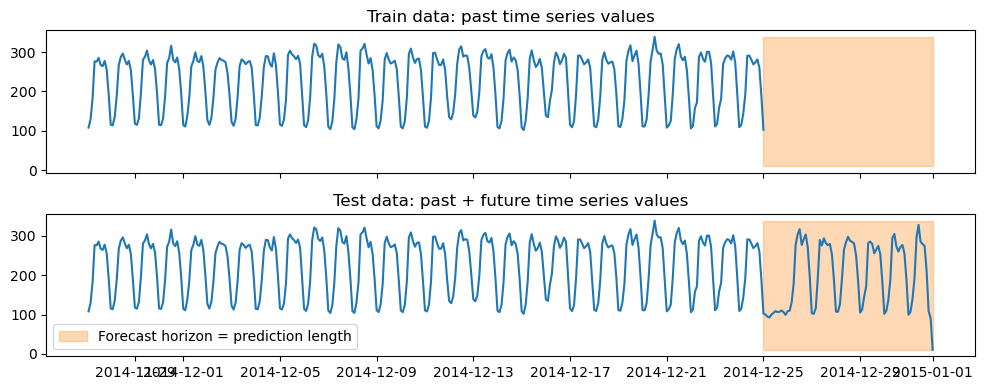

In [254]:
item_id = test_df.item_ids[0]
n_history = 4

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=[10, 4], sharex=True)
train_ts = train_df.slice_by_timestep(start_index=-n_history*prediction_length).loc[item_id]
test_ts = test_df.slice_by_timestep(start_index=-(n_history+1)*prediction_length).loc[item_id]

ax1.set_title("Train data: past time series values")
ax1.plot(train_ts)
ax2.set_title("Test data: past + future time series values")
ax2.plot(test_ts)
for ax in (ax1, ax2):
    ax.fill_between(np.array([train_ts.index[-1], test_ts.index[-1]]), test_ts.min(), test_ts.max(), color="C1", alpha=0.3, label="Forecast horizon = prediction length")
plt.legend()
plt.tight_layout()
plt.show()

### Fit models

Use the AutoGluon [`TimeSeriesPredictor`](https://auto.gluon.ai/stable/api/autogluon.timeseries.TimeSeriesPredictor.html) class to train models and do inference.

`TimeSeriesPredictor` provides probabilistic (quantile) multi-step-ahead forecasts for **univariate time series**. The forecast includes both the mean - conditional expectation of future values given the past, as well as the quantiles of the forecast distribution, indicating the range of possible future outcomes.

`TimeSeriesPredictor` fits both _global_ deep learning models that are shared across all time series such as DeepAR, Transformer, as well as _local_ statistical models that are fit to each individual time series such as ARIMA, ETS.

You can include covariates known as dynamic features, exogenous variables, additional regressors or related time series into training. Examples of such covariates include holidays, promotions or weather forecasts. See the AutoGluon documentation for more details and examples.

In [211]:
timestamp = strftime("%Y%m%d-%H%M%S", gmtime())
experiment_name = f"{experiment_prefix}-{freq}-{ts_wide_df.shape[1]}-{ts_wide_df.shape[0]}"
eval_metric = 'WQL'
forecast_quantiles = [0.1, 0.5, 0.9]
predictor_data_path = f"{experiment_name}-{timestamp}"

In [212]:
start_dataset = test_df.index.get_level_values(1)[0]
end_dataset = test_df.index.get_level_values(1)[-1]

In [213]:
predictor = TimeSeriesPredictor(
    target="target",
    prediction_length=prediction_length,
    eval_metric=eval_metric,
    quantile_levels=forecast_quantiles,
    path=predictor_data_path, 
)

Now run [`fit()`](https://auto.gluon.ai/stable/api/autogluon.timeseries.TimeSeriesPredictor.fit.html#autogluon.timeseries.TimeSeriesPredictor.fit) method to train models. 


You can provide a time limit in seconds in the parameter `time_limit` to fit the training in your time budget. If not provided, `fit()` will run until all models have completed training.

Use the `presets` parameter to control a trade-off between the training speed and quality of results. Depending on the parameter value, AutoGluon can train simple statistical models and fast tree-based models for short training time or use all available models plus additional statistical models for more accurate predictions but longer training time. Note that Chronos has own presents in AutoGluon.

If you're not familiar with AutoGluon, it's recommended to use `presets` and avoid specifying most other `fit()` parameters.

If not specified otherwise in the parameter `enable_ensemble`, AutoGluon will fit a weighted ensemble on top of trained models.

<div class="alert alert-info">
The training of the full dataset takes about 60 min on instances with 8 vCPU and and about 45 min on an instances with 16 vCPU.
</div>

#### Fit time by instance type
This section provides some guidance on training times on various CPU and GPU instances. All training runs used `high_quality` presets. The full dataset contains 370 timeseries and 6.5 million rows, the small contains 2 time series and 35'000 rows. 

Tests used the following SageMaker [instance types](https://aws.amazon.com/sagemaker/pricing/):
- CPU-instances: standard `ml.m7i.2xlarge`, `ml.m7i.4xlarge`, and `ml.m7i.24xlarge`, compute optimized `ml.c5.4xlarge` and `ml.c7i.2xlarge`, memory optimized `ml.r7i.2xlarge`
- GPU-instances: Single GPU `ml.g5.2xlarge` and `ml.g5.4xlarge`, 4x GPU `ml.g5.12xlarge`

The main factor for training time is the amount of CPUs. Both CPU and GPU instances with 16 vCPUs shown similar performance on the full dataset. For the small dataset, the GPU instances with 16 vCPU were about 60% faster than CPU instances. The recommended instance type for this dataset, both small and full versions, is `ml.g5.4xlarge`.

<div class="alert alert-info">Note that you need a GPU instance to use larger Chronos models.</div>

Now visualize the data points.

In [214]:
data_cpu_full = {
    'instance_type': ['ml.c5.4xlarge', 'ml.c7i.2xlarge', 'ml.m7i.2xlarge', 'ml.m7i.4xlarge', 'ml.m7i.24xlarge', 'ml.r7i.2xlarge'],
    'fit_time': [2671.17, 3969.44, 3863.30, 2241.30, 2386.65, 3864.86 ],
}

data_gpu_full = {
    'instance_type': ['ml.g5.2xlarge', 'ml.g5.4xlarge', 'ml.g5.12xlarge'],
    'fit_time': [3690.43, 2563.35, 1917.52],
}

data_cpu_small = {
    'instance_type': ['ml.c5.4xlarge', 'ml.c7i.2xlarge', 'ml.m7i.2xlarge', 'ml.m7i.4xlarge', 'ml.m7i.24xlarge', 'ml.r7i.2xlarge'],
    'fit_time': [815.22, 1098.92, 519.09, 443.99, 485.83, 751.10],  
}

data_gpu_small = {
    'instance_type': ['ml.g5.2xlarge', 'ml.g5.4xlarge', 'ml.g5.12xlarge'],
    'fit_time': [396.90, 328.97, 331.37], 
}

In [215]:
# use Pricing API to get information about SageMaker instances
pricing = boto3.client('pricing')
service_code = 'AmazonSageMaker'
attribute_name = 'instanceName'
attr_list = ['computeType', 'vCpu', 'memory', 'gpu', 'physicalCpu',]

# get instance attributes
instance_data = {
    i:{
        a:json.loads(pricing.get_products(
            ServiceCode=service_code,
            Filters=json.loads(f'[{{"Type":"TERM_MATCH","Field":"{attribute_name}","Value":"{i}"}}]'),
        )['PriceList'][0])['product']['attributes'][a] for a in attr_list
    }
    for i in data_cpu_full['instance_type'] + data_gpu_full['instance_type']
}

# Create the DataFrame
instance_data_df = pd.DataFrame.from_dict(instance_data, orient='index').reset_index().rename(columns={'index': 'instance_type'})

In [216]:
def create_bar_chart(ax, data_cpu, data_gpu, title):
    all_instance_types = data_cpu['instance_type'] + data_gpu['instance_type']
    all_fit_times = data_cpu['fit_time'] + data_gpu['fit_time']

    bar_width = 0.6
    r1 = np.arange(len(all_instance_types))

    bars = ax.bar(r1, all_fit_times, color=plt.cm.Set3(np.linspace(0, 1, len(all_instance_types))), width=bar_width)

    ax.set_xlabel('Instance type')
    ax.set_ylabel('Fit time (seconds)')
    ax.set_title(title)
    ax.set_xticks(r1)
    ax.set_xticklabels(all_instance_types, rotation=45, ha='right')

    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.0f}',
                ha='center', va='bottom', rotation=0)

    cpu_patch = plt.Rectangle((0,0),1,1,fc="lightblue", edgecolor = 'none')
    gpu_patch = plt.Rectangle((0,0),1,1,fc="lightgreen", edgecolor = 'none')
    ax.legend([cpu_patch, gpu_patch], ['CPU instances', 'GPU instances'], loc='upper right')

    for i, bar in enumerate(bars):
        if i < len(data_cpu['instance_type']):
            bar.set_facecolor('lightblue')
        else:
            bar.set_facecolor('lightgreen')

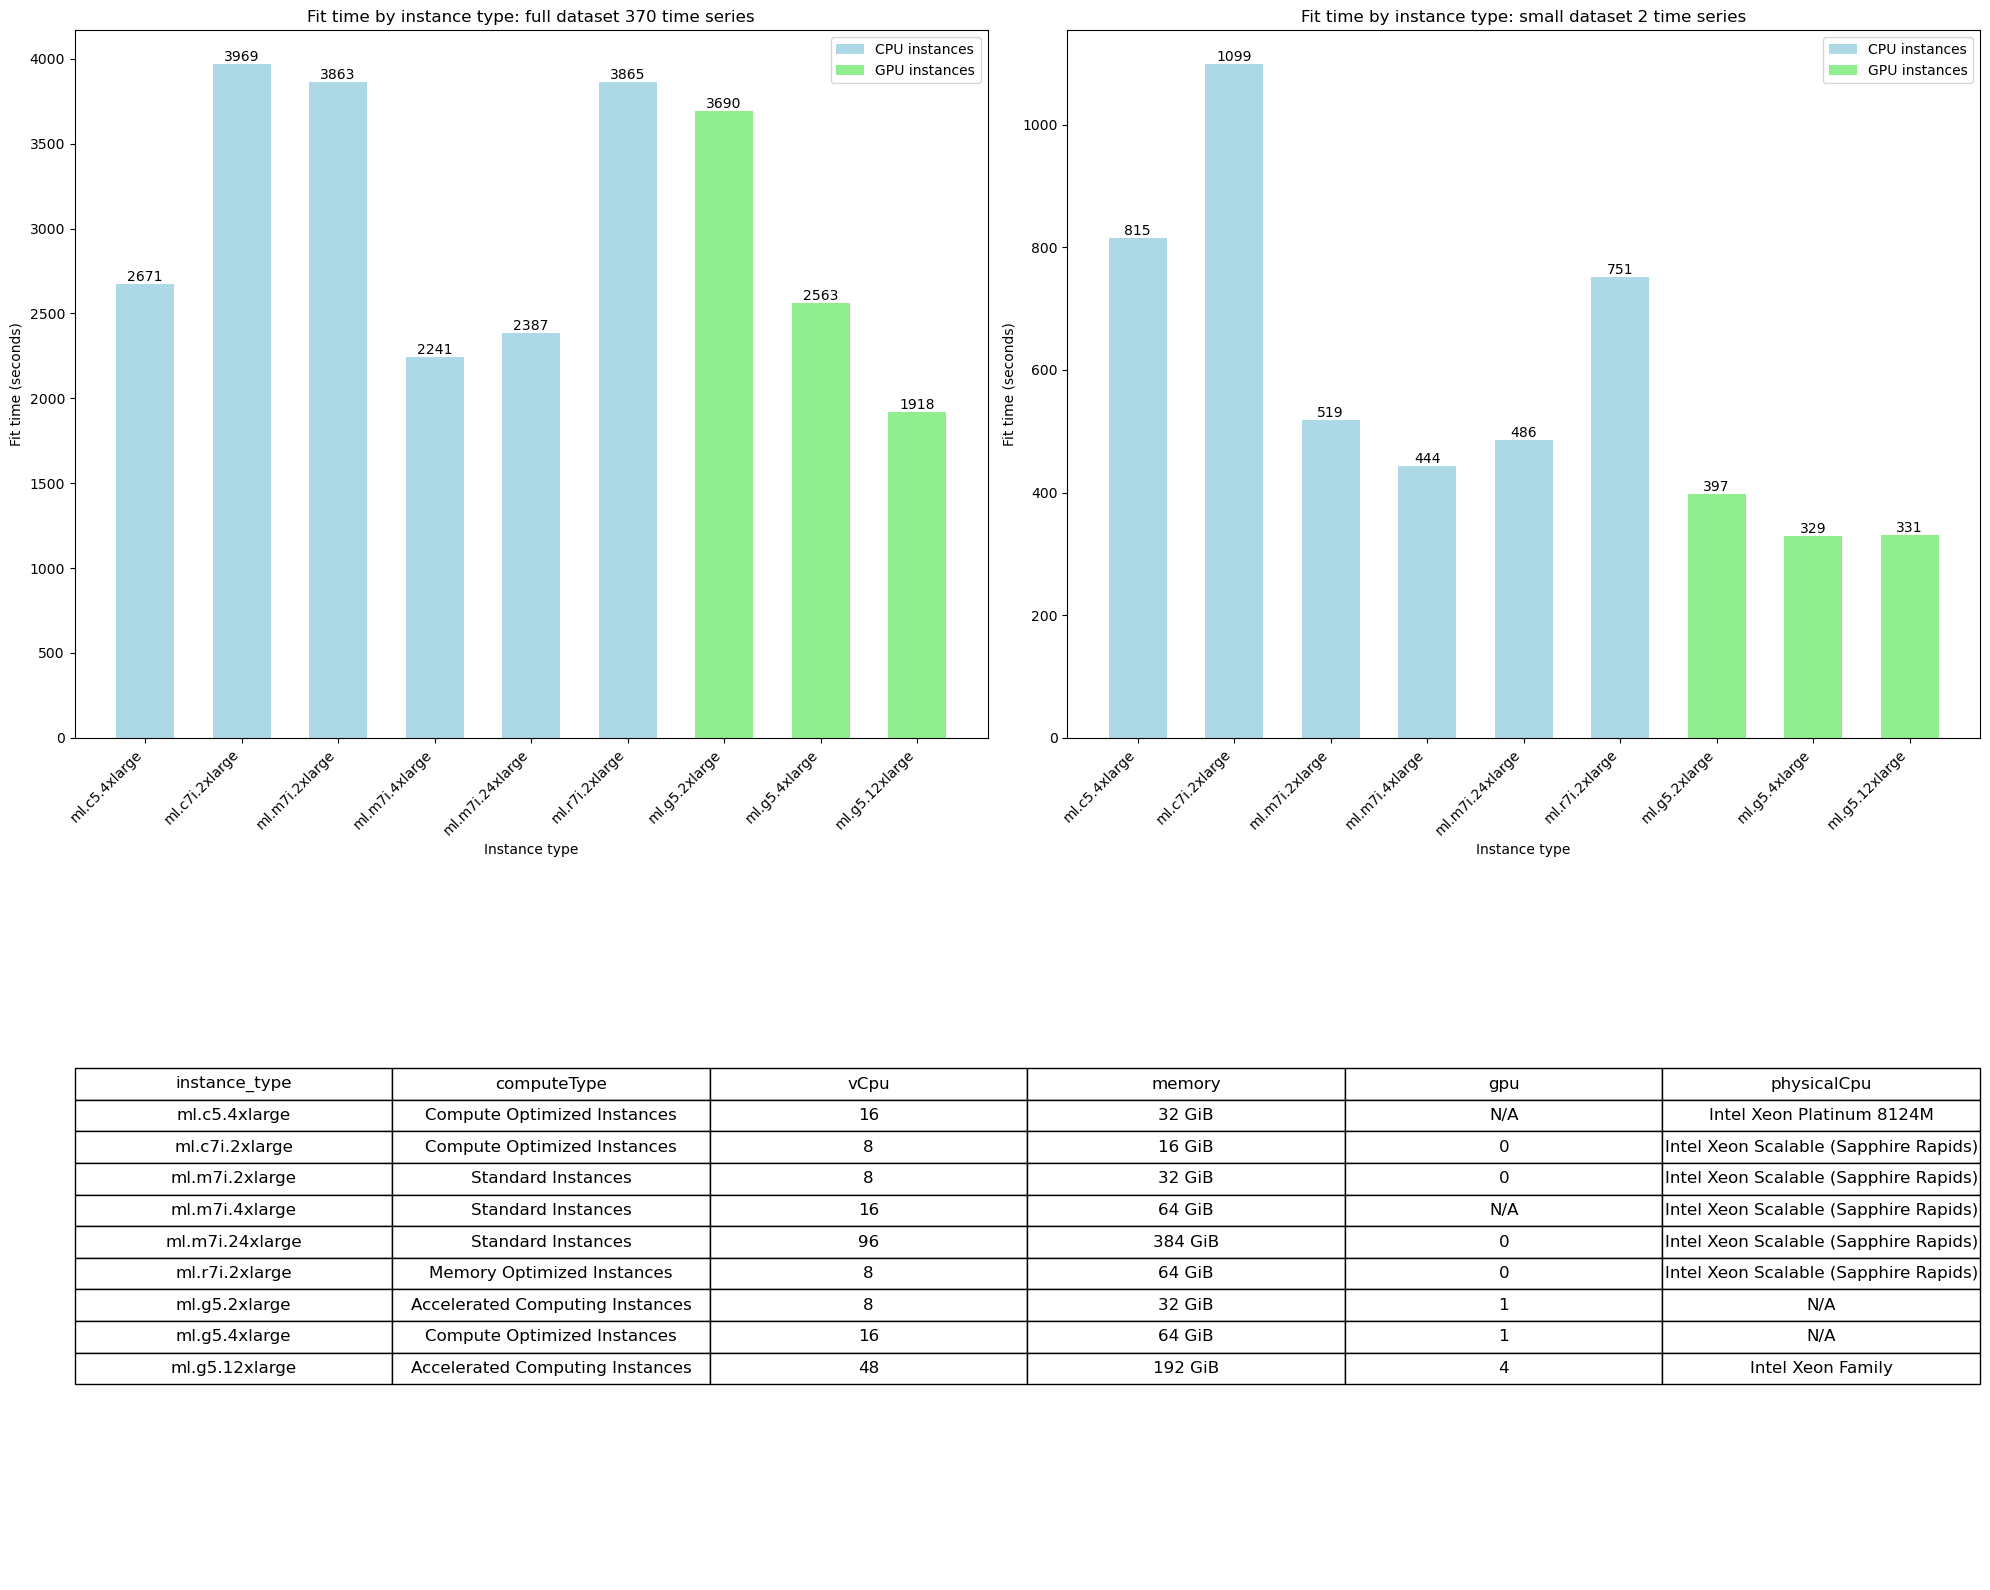

In [217]:
fig = plt.figure(figsize=(20, 16))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1])

# Create the subplots
ax1, ax2, ax3 = fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1]), fig.add_subplot(gs[1, :])

create_bar_chart(ax1, data_cpu_full, data_gpu_full, f'Fit time by instance type: full dataset {data_kw.shape[1]} time series')
create_bar_chart(ax2, data_cpu_small, data_gpu_small, f'Fit time by instance type: small dataset {data_kw_small.shape[1]} time series')

ax3.axis('off')
table = ax3.table(cellText=instance_data_df.values, colLabels=instance_data_df.columns, loc='center', cellLoc='center')

# Adjust table style
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 1.5)

# Adjust layout to prevent clipping of tick-labels
plt.tight_layout()
plt.show()

In [218]:
predictor.fit(
    train_data=train_df,
    # time_limit=30*60,
    presets="high_quality",
)

Beginning AutoGluon training...
AutoGluon will save models to 'autogluon-2H-2-17533-20240914-143614'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.14
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Aug 7 16:53:32 UTC 2024
CPU Count:          16
GPU Count:          1
Memory Avail:       55.37 GB / 62.12 GB (89.1%)
Disk Space Avail:   94.64 GB / 99.95 GB (94.7%)
Setting presets to: high_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 84,
 'quantile_levels': [0.1, 0.5, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: '2H'
Provided train_data has 34898 rows, 2 time series. Median time series length is 17449 (min=17449, max=17449). 


## Working with trained predictor

After training completed, you can access all information via `TimeSeriesPredictor` class.

In [219]:
# Detailed information about models trained
predictor.fit_summary()

****************** Summary of fit() ******************
Estimated performance of each model:
                        model  score_val  pred_time_val  fit_time_marginal  \
0            WeightedEnsemble  -0.050758       4.656196           0.780749   
1   TemporalFusionTransformer  -0.055398       0.041756         152.201767   
2               DirectTabular  -0.057226       0.139586           4.787616   
3                    PatchTST  -0.057589       0.028193          32.483785   
4                        NPTS  -0.063106       2.137445           0.031716   
5                      DeepAR  -0.065746       0.360375          95.879372   
6                   AutoARIMA  -0.069427      15.710104           0.029119   
7                     AutoETS  -0.069531      18.476736           0.030277   
8               SeasonalNaive  -0.070390       1.386272           0.032085   
9               Chronos[base]  -0.074197       2.309216           0.023293   
10           RecursiveTabular  -0.080898       1.8

{'model_types': {'SeasonalNaive': 'MultiWindowBacktestingModel',
  'RecursiveTabular': 'MultiWindowBacktestingModel',
  'DirectTabular': 'MultiWindowBacktestingModel',
  'CrostonSBA': 'MultiWindowBacktestingModel',
  'NPTS': 'MultiWindowBacktestingModel',
  'DynamicOptimizedTheta': 'MultiWindowBacktestingModel',
  'AutoETS': 'MultiWindowBacktestingModel',
  'AutoARIMA': 'MultiWindowBacktestingModel',
  'Chronos[base]': 'MultiWindowBacktestingModel',
  'TemporalFusionTransformer': 'MultiWindowBacktestingModel',
  'DeepAR': 'MultiWindowBacktestingModel',
  'PatchTST': 'MultiWindowBacktestingModel',
  'WeightedEnsemble': 'TimeSeriesGreedyEnsemble'},
 'model_performance': {'SeasonalNaive': -0.07039030459536406,
  'RecursiveTabular': -0.08089833380121793,
  'DirectTabular': -0.057226462306863124,
  'CrostonSBA': -0.25855193674375226,
  'NPTS': -0.0631062817859353,
  'DynamicOptimizedTheta': -0.13998978156710853,
  'AutoETS': -0.06953094138069078,
  'AutoARIMA': -0.0694271444931827,
  'Chron

In [220]:
# Dictionary of model details
predictor.info()

{'path': 'autogluon-2H-2-17533-20240914-143614',
 'version': '1.1.1',
 'time_fit_training': 400.8572816848755,
 'time_limit': None,
 'best_model': 'WeightedEnsemble',
 'best_model_score_val': -0.050758423909317195,
 'num_models_trained': 13,
 'model_info': {'SeasonalNaive': {'name': 'SeasonalNaive',
   'model_type': 'MultiWindowBacktestingModel',
   'eval_metric': WQL,
   'fit_time': 0.03208518028259277,
   'predict_time': 1.3862719535827637,
   'freq': '2H',
   'prediction_length': 84,
   'quantile_levels': [0.1, 0.5, 0.9],
   'val_score': -0.07039030459536406,
   'hyperparameters': {},
   'info_per_val_window': [{'window_index': 0,
     'refit_this_window': True,
     'fit_time': 0.005460023880004883,
     'val_score': -0.07039030459536406,
     'predict_time': 1.3862719535827637}]},
  'RecursiveTabular': {'name': 'RecursiveTabular',
   'model_type': 'MultiWindowBacktestingModel',
   'eval_metric': WQL,
   'fit_time': 45.88935327529907,
   'predict_time': 1.8871173858642578,
   'freq

See the AutoGluon documentation on the [`leaderboard()`](https://auto.gluon.ai/stable/api/autogluon.timeseries.TimeSeriesPredictor.leaderboard.html) method for description of each shown column.

In [221]:
# Model leaderboard with scoring
predictor.leaderboard()

,model,score_val,pred_time_val,fit_time_marginal,fit_order
0,WeightedEnsemble,-0.050758,4.656196,0.780749,13
1,TemporalFusionTransformer,-0.055398,0.041756,152.201767,10
2,DirectTabular,-0.057226,0.139586,4.787616,3
3,PatchTST,-0.057589,0.028193,32.483785,12
4,NPTS,-0.063106,2.137445,0.031716,5
5,DeepAR,-0.065746,0.360375,95.879372,11
6,AutoARIMA,-0.069427,15.710104,0.029119,8
7,AutoETS,-0.069531,18.476736,0.030277,7
8,SeasonalNaive,-0.070390,1.386272,0.032085,1
9,Chronos[base],-0.074197,2.309216,0.023293,9


In [222]:
# You can provide a dataset to evaluate the model leaderboard based on the test data
predictor.leaderboard(test_df)

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,DirectTabular,-0.065607,-0.057226,0.147866,0.139586,4.787616,3
1,TemporalFusionTransformer,-0.096103,-0.055398,0.093426,0.041756,152.201767,10
2,WeightedEnsemble,-0.099202,-0.050758,4.842763,4.656196,0.780749,13
3,PatchTST,-0.101307,-0.057589,0.050039,0.028193,32.483785,12
4,AutoARIMA,-0.108179,-0.069427,17.722354,15.710104,0.029119,8
5,DeepAR,-0.111870,-0.065746,0.374859,0.360375,95.879372,11
6,RecursiveTabular,-0.114451,-0.080898,1.355885,1.887117,45.889353,2
7,NPTS,-0.122397,-0.063106,2.148469,2.137445,0.031716,5
8,SeasonalNaive,-0.202132,-0.070390,0.949472,1.386272,0.032085,1
9,DynamicOptimizedTheta,-0.205736,-0.139990,19.147353,19.242766,0.029604,6


To load all saved predictor data including the model leaderboard, logs, and the trained model you use the [`load()`](https://auto.gluon.ai/stable/api/autogluon.timeseries.TimeSeriesPredictor.load.html) method of the `TimeSeriesPredictor` class.

In [223]:
# list all autogluon data saved to the EBS volume
!ls -dt {experiment_prefix}*/

autogluon-2H-2-17533-20240914-143614/
autogluon-chronos-2H-2-17533-20240913-132014/
autogluon-2H-2-17533-20240913-131221/


In [224]:
# uncomment if you need to load a predictor from the saved data
# predictor_data_path="autogluon-2H-370-17533-20240905-214138"
# predictor = TimeSeriesPredictor.load(predictor_data_path)

### Model performance

To measure how accurately `TimeSeriesPredictor` can forecast unseen time series, you can use the method [`TimeSeriesPredictor.evaluate()`](https://auto.gluon.ai/stable/api/autogluon.timeseries.TimeSeriesPredictor.evaluate.html). This method measures the model accuracy using the last `prediction_length` time steps of each time series in data as a hold-out set, in this case in the dataset `test_df`.

In [225]:
metrics = ['WQL', 'MAPE', 'WAPE', 'RMSE', 'MASE']
# You can also specify a model name via `model` parameter
model_metrics = predictor.evaluate(
    data=test_df, 
    metrics=metrics, 
    # model="DeepAR", 
    display=True)

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble
Evaluations on test data:
{
    "WQL": -0.09920228851600811,
    "MAPE": -0.3185656262425179,
    "WAPE": -0.13246009074345497,
    "RMSE": -102.58101536402036,
    "MASE": -2.373443819404882
}


#### Save the model performance to a file

In [226]:
def display_and_save_metrics(
    model_metrics,
    experiment_name,
    timestamp=strftime("%Y%m%d-%H%M%S", gmtime()),
    display_only=False,
):
    model_metrics_df = pd.DataFrame.from_dict(model_metrics, orient='index', columns=['value']).reset_index().rename(columns={'index': 'metric_name'})
    model_metrics_df['experiment'] = experiment_name
    model_metrics_df['timestamp'] = timestamp
    # AutoGluon flips the sign of a metric, multiply by -1
    model_metrics_df['value'] = model_metrics_df['value'] * (-1)
    model_metrics_df = model_metrics_df[['timestamp','metric_name','value','experiment']]

    print(model_metrics_df)

    if not display_only:
        model_metrics_df.to_csv(f'./model-performance/{experiment_name}-{timestamp}.csv', index=False)

    return model_metrics_df

In [227]:
os.makedirs("./model-performance", exist_ok=True)

In [228]:
display_and_save_metrics(model_metrics, experiment_name, timestamp)

         timestamp metric_name       value            experiment
0  20240914-143614         WQL    0.099202  autogluon-2H-2-17533
1  20240914-143614        MAPE    0.318566  autogluon-2H-2-17533
2  20240914-143614        WAPE    0.132460  autogluon-2H-2-17533
3  20240914-143614        RMSE  102.581015  autogluon-2H-2-17533
4  20240914-143614        MASE    2.373444  autogluon-2H-2-17533


,timestamp,metric_name,value,experiment
0,20240914-143614,WQL,0.099202,autogluon-2H-2-17533
1,20240914-143614,MAPE,0.318566,autogluon-2H-2-17533
2,20240914-143614,WAPE,0.132460,autogluon-2H-2-17533
3,20240914-143614,RMSE,102.581015,autogluon-2H-2-17533
4,20240914-143614,MASE,2.373444,autogluon-2H-2-17533


## Generate predictions and visualize

To generate predictions and to plot the results you use the methonds [`predict()`](https://auto.gluon.ai/stable/api/autogluon.timeseries.TimeSeriesPredictor.predict.html) and [`plot()`](https://auto.gluon.ai/stable/api/autogluon.timeseries.TimeSeriesPredictor.plot.html) of the `TimeSeriesPredictor`.

In [229]:
# persist models in memory for reduced inference latency
predictor.persist()

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


['PatchTST',
 'DirectTabular',
 'TemporalFusionTransformer',
 'Chronos[base]',
 'NPTS',
 'WeightedEnsemble']

In [230]:
prediction_df = predictor.predict(test_df)

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


`predict()` method generates `prediction_length` starting from the end of the provided time series:

In [231]:
prediction_df

mean         0.1          0.5          0.9
item_id timestamp                                                             
MT_227  2015-01-01 02:00:00    87.282498   61.207016    85.514986   128.428738
        2015-01-01 04:00:00   119.578541   80.750617   124.645758   173.635153
        2015-01-01 06:00:00   187.976660  134.027380   199.343700   240.903937
        2015-01-01 08:00:00   251.978385  189.816501   261.498909   288.136646
        2015-01-01 10:00:00   271.963194  204.189593   282.359636   306.870521
...                                  ...         ...          ...          ...
MT_098  2015-01-07 16:00:00  1087.006723  975.594834  1084.064745  1183.392168
        2015-01-07 18:00:00  1029.537007  936.649550  1027.868235  1148.537701
        2015-01-07 20:00:00   836.800121  745.815767   837.937092   981.783527
        2015-01-07 22:00:00   487.892235  425.502158   493.512282   564.315766
        2015-01-08 00:00:00   243.897954  210.642031   244.932737   288.752904

[168 rows x 4 columns]

`plot()` method plots predictions together with historical time series and confidence interval based on forecast quantiles.

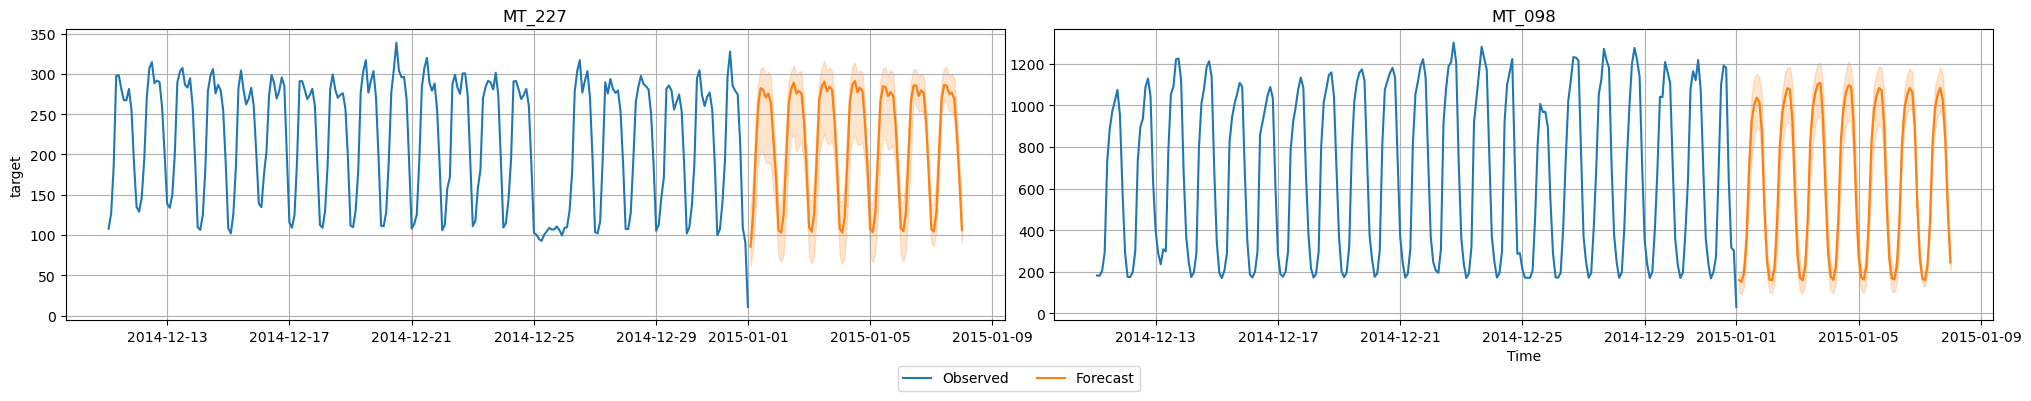

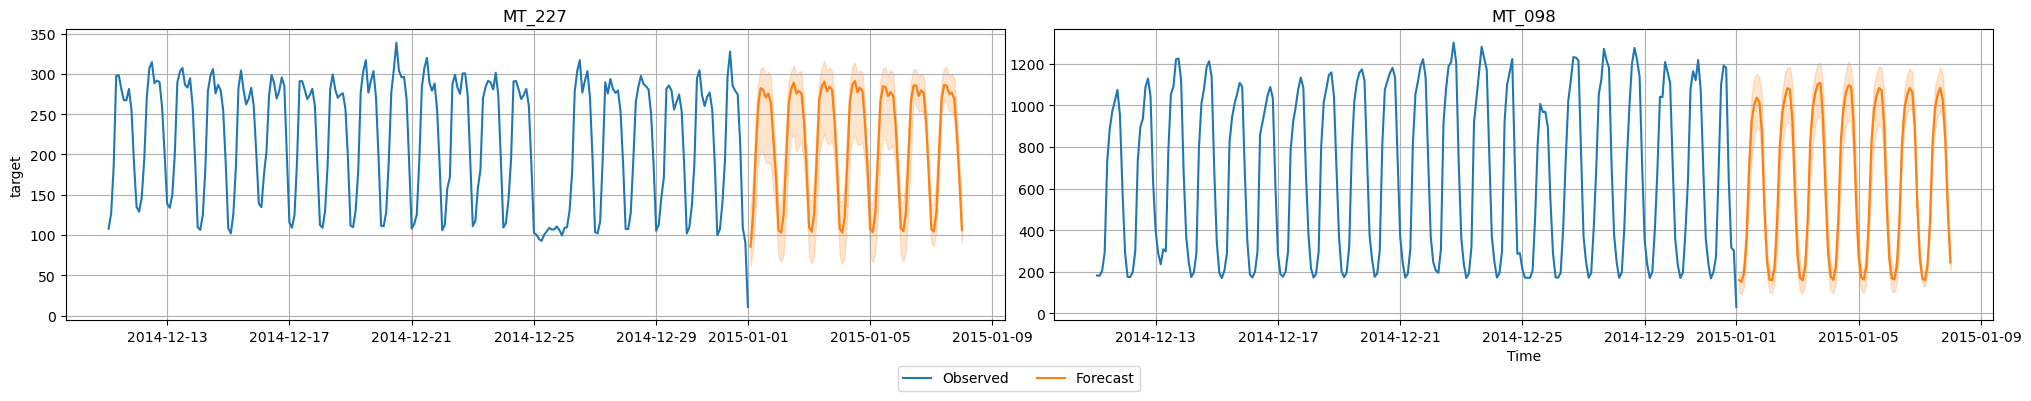

In [256]:
predictor.plot(
    data=test_df,
    predictions=prediction_df,
    quantile_levels=forecast_quantiles,
    item_ids=prediction_df.item_ids[0:2],
    max_history_length=prediction_length*3,   
)

Experiment with different trained models and prediction dates to generate forecast. You can change the following parameters:

- `Model`: select any model from the predictor's leaderboard
- `Time series ids`: id of the time series to forecast. You can select multiple time series to plot together
- `Offset days`: how many days back from the data end the prediction starts
- `History lenght`: how many 'prediction lengths' of history are shown on the plot as the history series

In [233]:
style = {"description_width": "initial"}
ts_id_list = test_df.item_ids.to_list()

In [234]:
@interact_manual(
    model=Dropdown(options=predictor.leaderboard()['model'].to_list(), description='Model:'),
    ts_ids=SelectMultiple(options=ts_id_list,value=[ts_id_list[0]], rows=5, style=style, description='Time series ids:'),
    offset_days=IntSlider(min=-365, max=0, value=0, style=style, description='Offset days:'),
    history_length=IntSlider(min=1, max=10, value=3, style=style, description='History length:'),
    continuous_update=False,
)
def plot_interact(
    model,
    ts_ids,
    offset_days,
    history_length,
):
    offset = -offset_days * intervals_per_day + 1
    data_end_index = offset - prediction_length + 1

    data_df = test_df.slice_by_timestep(end_index=-data_end_index) if offset > prediction_length else test_df
    inference_df = test_df.slice_by_timestep(end_index=-offset)
    prediction_df = predictor.predict(data=inference_df, model=model)
        
    predictor.plot(
        data=data_df,
        predictions=prediction_df,
        quantile_levels=forecast_quantiles,
        item_ids=list(ts_ids),
        max_history_length=history_length*prediction_length,   
    )

    plt.show()

interactive(children=(Dropdown(description='Model:', options=('WeightedEnsemble', 'TemporalFusionTransformer',…

---

## Use Chronos with AutoGluon

This section uses content from the AutoGluon documentation [Forecasting with Chronos](https://auto.gluon.ai/stable/tutorials/timeseries/forecasting-chronos.html).

<div class="alert alert-info">If you run this notebook on a CPU-only instance, you can use Chronos models <code>tiny</code> and <code>mini</code> only.</div>

Chronos on AutoGluon is available in five model sizes with different [numbers of parameters](https://github.com/amazon-science/chronos-forecasting/tree/main?tab=readme-ov-file#architecture): `tiny` (8M), `mini` (20M), `small` (46M), `base` (200M), and `large` (710M). 

Being a pretrained transformer model for zero-shot forecasting, Chronos is different from other models available in AutoGluon Time Series. Chronos models do not really fit time series data during training time with `fit()`. When `predict()` is called, it carries out a relatively more expensive computation that scales linearly with the number of time series in the dataset. In this aspect, they behave like local statistical models such as ETS or ARIMA, or generative AI foundation models where expensive computation happens during inference. Computation for `small`, `base`, and `large` Chronos models requires a GPU accelerator chip to run in a reasonable amount of time.

The easiest way to get started with Chronos is through model-specific presets available in the [`TimeSeriesPredictor.fit()`](https://auto.gluon.ai/stable/api/autogluon.timeseries.TimeSeriesPredictor.fit.html). As of v1.1, the `fit()` method has five specific Chronos preset for each model size, such as `chronos_small` or `chronos_base` and two Chronos-specific ensemble presets.

In ensemble mode Chronos `base` or `large` models are combined with other time series models using presets `chronos_ensemble` and `chronos_large_ensemble`. More details about these presets are available in the documentation for [`TimeSeriesPredictor.fit()`](https://auto.gluon.ai/stable/api/autogluon.timeseries.TimeSeriesPredictor.fit.html).

Note that the model sizes `small` and higher require a GPU to run.

### Create a predictor
Create a `TimeSeriesPredictor` for Chronos usage.

In [235]:
train_df.shape

(34898, 1)

In [236]:
chronos_predictor = TimeSeriesPredictor(
    target="target",
    prediction_length=prediction_length,
    eval_metric=eval_metric,
    quantile_levels=forecast_quantiles,
    path=chronos_predictor_data_path, 
)

### Fit Chronos models

In [237]:
number_of_gpus = torch.cuda.device_count()
print(f"Number of GPUs available: {number_of_gpus}")

if number_of_gpus < 1:
    chronos_size = 'mini'
elif number_of_gpus == 1:
    chronos_size = 'base'
else:
    chronos_size = 'large'

Number of GPUs available: 1


In [238]:
chronos_predictor.fit(
    train_data=train_df,
    presets=f"chronos_{chronos_size}",
)

Beginning AutoGluon training...
AutoGluon will save models to 'autogluon-Chronos[base]-2H-2-17533-20240913-170726'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.14
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Aug 7 16:53:32 UTC 2024
CPU Count:          16
GPU Count:          1
Memory Avail:       53.26 GB / 62.12 GB (85.7%)
Disk Space Avail:   94.62 GB / 99.95 GB (94.7%)
Setting presets to: chronos_base

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'base'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 84,
 'quantile_levels': [0.1, 0.5, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: '2H'
Provided train_data has 34898 rows, 2 time series. Median time series le

In [239]:
chronos_predictor.leaderboard()

,model,score_val,pred_time_val,fit_time_marginal,fit_order
0,Chronos[base],None,None,0.000185,1


As you can see, Chronos does not take any time to `fit`. The `fit` still does some of tasks under the hood, such as inferring the frequency of time series and saving the predictor's state to disk.

### Generate predictions and visualize

Use the `predict()` method to generate forecasts, and the `plot()` method to visualize them.

In [240]:
test_df.shape

(35066, 1)

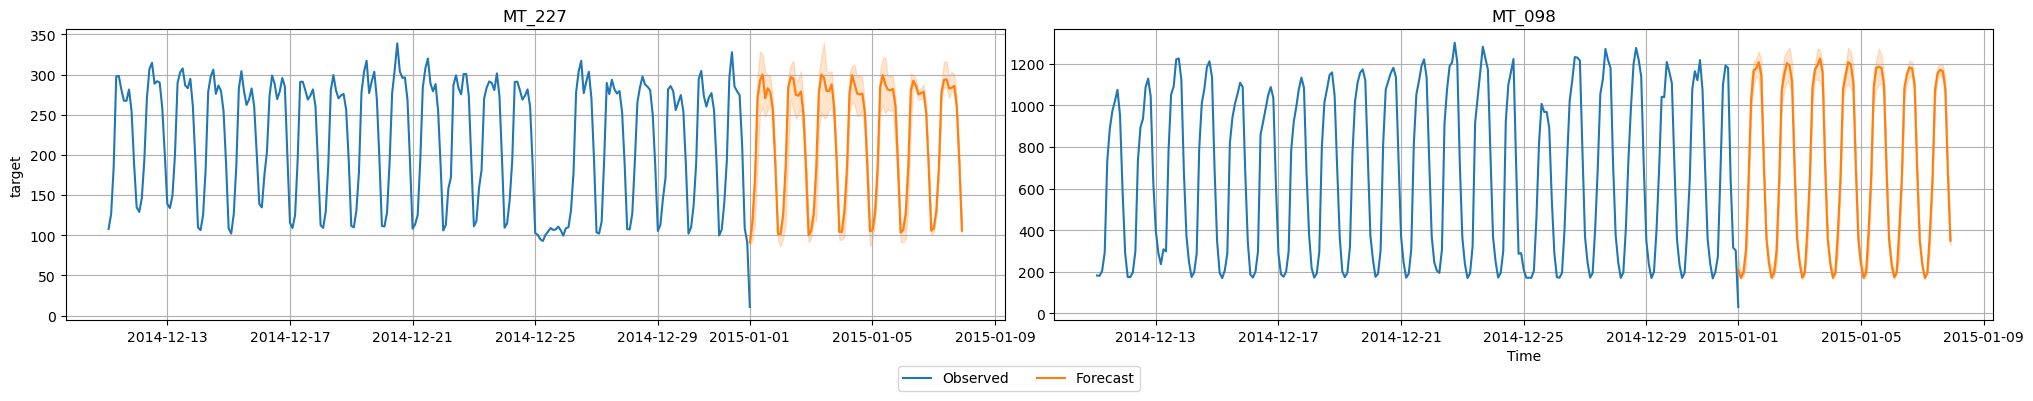

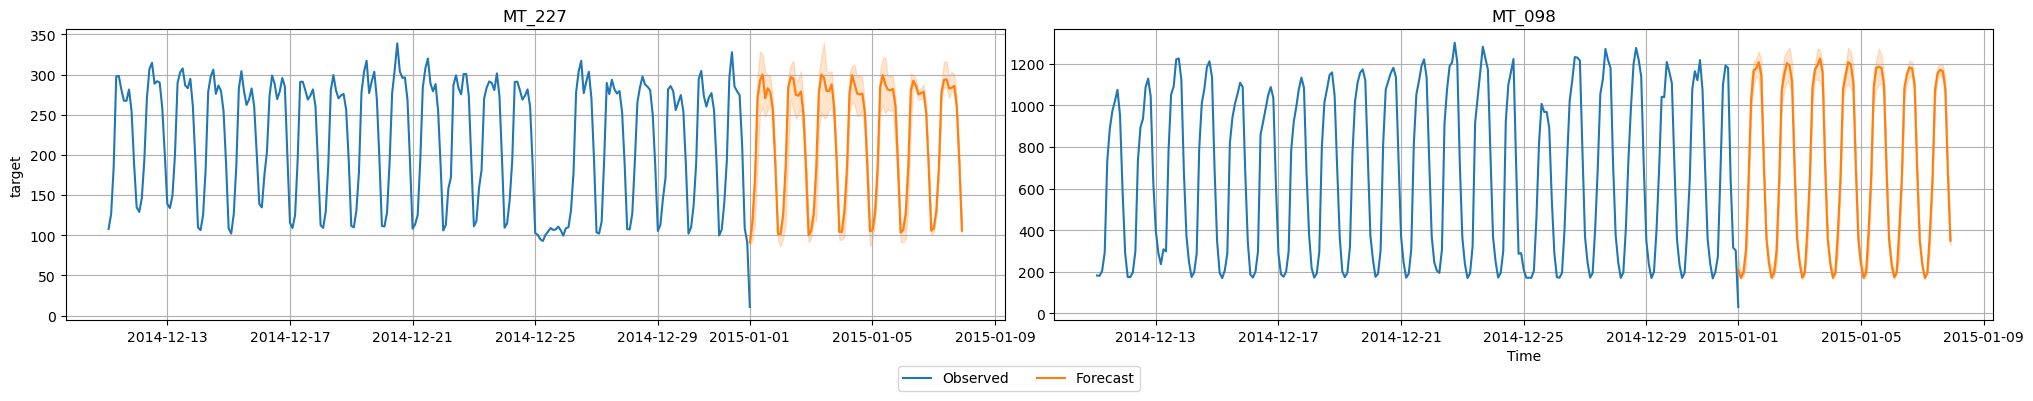

In [260]:
model = chronos_predictor.leaderboard()['model'][0]

# remove the last time step in the test dataset because of the artifact where the target goes to zero
chronos_prediction_df = chronos_predictor.predict(data=test_df.slice_by_timestep(end_index=-1), model=model)

chronos_predictor.plot(
    data=test_df,
    predictions=chronos_prediction_df,
    quantile_levels=forecast_quantiles,
    item_ids=chronos_prediction_df.item_ids[:2],
    max_history_length=prediction_length*3,   
)

### Chronos model performance

In [242]:
chronos_model_metrics = chronos_predictor.evaluate(
    data=test_df.slice_by_timestep(end_index=-1), 
    metrics=metrics, 
    model=model,
    display=True)

Evaluations on test data:
{
    "WQL": -0.21757854348149328,
    "MAPE": -0.31318883966263933,
    "WAPE": -0.2482442611157005,
    "RMSE": -184.34089794560865,
    "MASE": -3.8854301559186966
}


In [243]:
timestamp = strftime("%Y%m%d-%H%M%S", gmtime())
chronos_experiment_name = f"{experiment_prefix}-{model}-{freq}-{ts_wide_df.shape[1]}-{ts_wide_df.shape[0]}"
chronos_predictor_data_path = f"{chronos_experiment_name}-{timestamp}"

print(f"Experiment name: {chronos_experiment_name}")

Experiment name: autogluon-Chronos[base]-2H-2-17533


In [244]:
display_and_save_metrics(chronos_model_metrics, chronos_experiment_name, timestamp)

         timestamp metric_name       value                          experiment
0  20240914-144417         WQL    0.217579  autogluon-Chronos[base]-2H-2-17533
1  20240914-144417        MAPE    0.313189  autogluon-Chronos[base]-2H-2-17533
2  20240914-144417        WAPE    0.248244  autogluon-Chronos[base]-2H-2-17533
3  20240914-144417        RMSE  184.340898  autogluon-Chronos[base]-2H-2-17533
4  20240914-144417        MASE    3.885430  autogluon-Chronos[base]-2H-2-17533


,timestamp,metric_name,value,experiment
0,20240914-144417,WQL,0.217579,autogluon-Chronos[base]-2H-2-17533
1,20240914-144417,MAPE,0.313189,autogluon-Chronos[base]-2H-2-17533
2,20240914-144417,WAPE,0.248244,autogluon-Chronos[base]-2H-2-17533
3,20240914-144417,RMSE,184.340898,autogluon-Chronos[base]-2H-2-17533
4,20240914-144417,MASE,3.885430,autogluon-Chronos[base]-2H-2-17533


#### Backtesting using multiple windows
You can more accurately estimate the performance using backtest with multiple windows by evaluating performance on multiple forecast horizons generated from the same time series.
The AutoGluon class `ExpandingWindowSplitter` provides the needed functionality to split the dataset.

Multi-window backtesting can result in more accurate estimation of the forecast quality on **unseen** data.

Window 0: score = {'WQL': -0.02949755927838484, 'MAPE': -0.0556614198087279, 'WAPE': -0.04207937931026257, 'RMSE': -25.858911290704405, 'MASE': -0.7817131125226889}
Window 1: score = {'WQL': -0.0284719338089903, 'MAPE': -0.04718729032832677, 'WAPE': -0.041209049582800916, 'RMSE': -28.614863784790582, 'MASE': -0.7314826692155696}
Window 2: score = {'WQL': -0.0751535809343813, 'MAPE': -0.08542710599463338, 'WAPE': -0.0918976884207106, 'RMSE': -90.48828507169101, 'MASE': -1.5011438582524625}
Window 3: score = {'WQL': -0.21757854348149328, 'MAPE': -0.31318883966263933, 'WAPE': -0.2482442611157005, 'RMSE': -184.34089794560865, 'MASE': -3.8854301559186966}


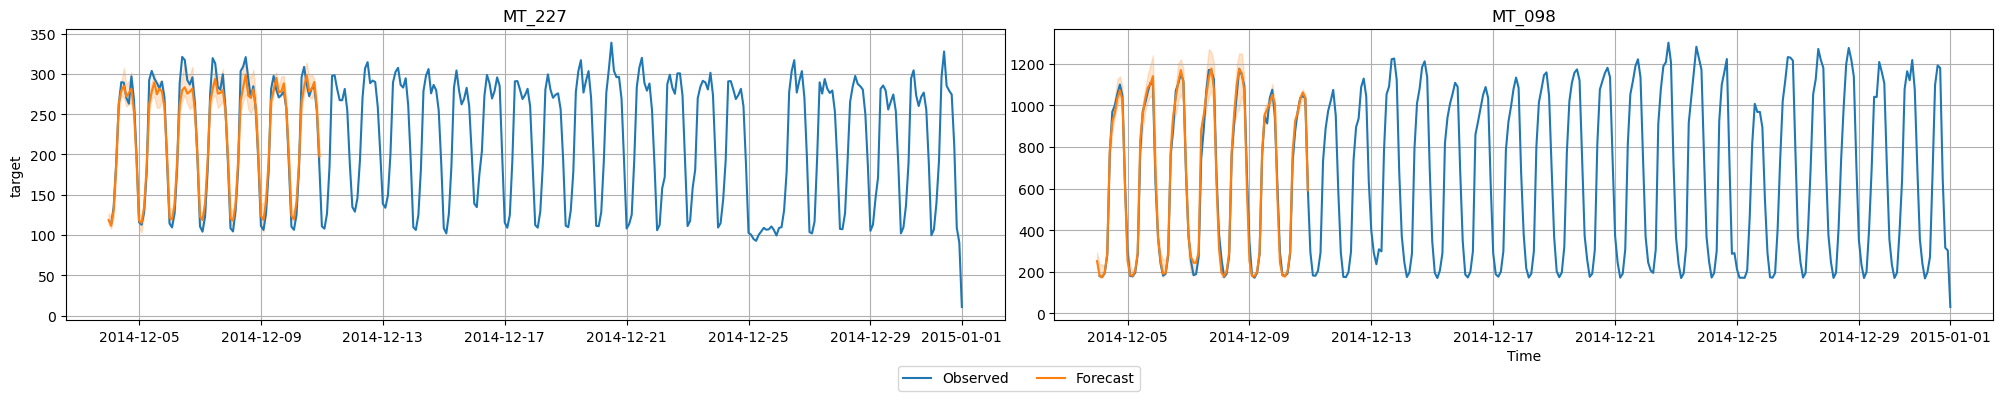

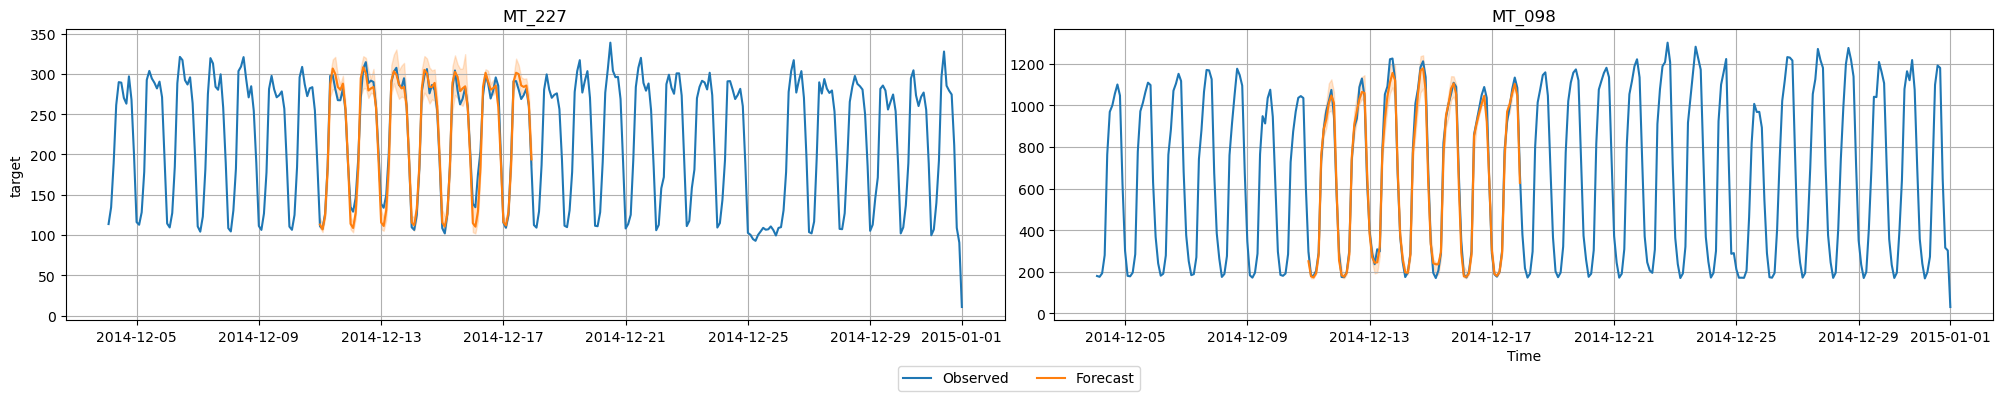

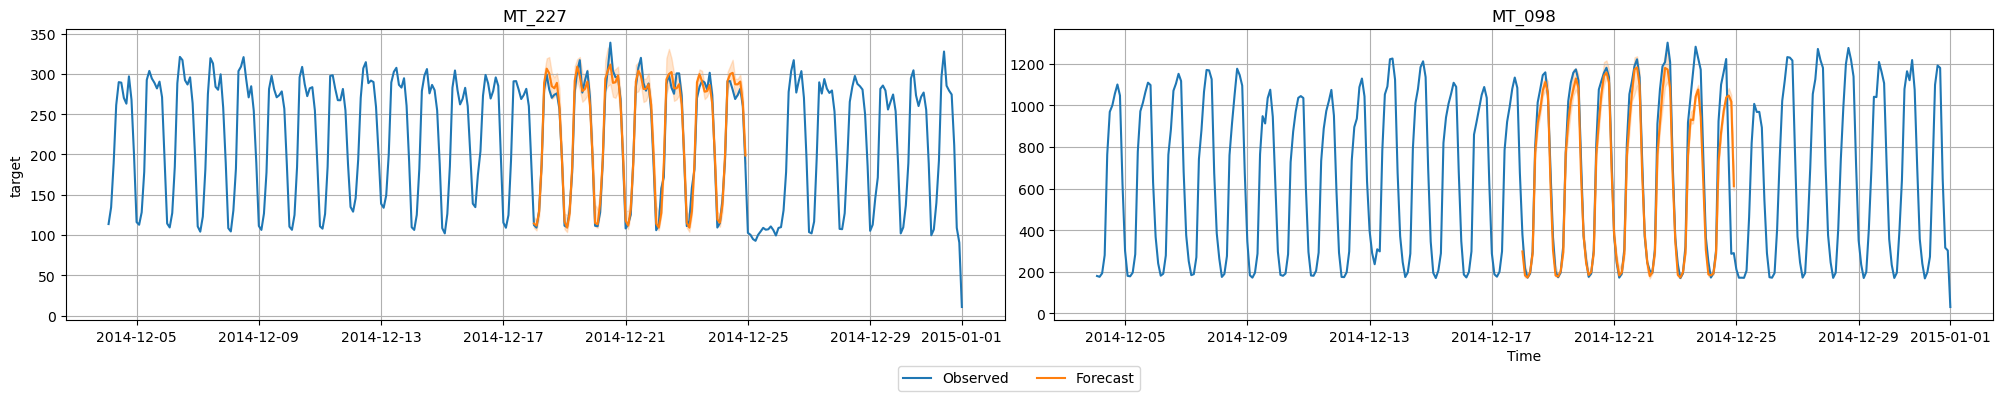

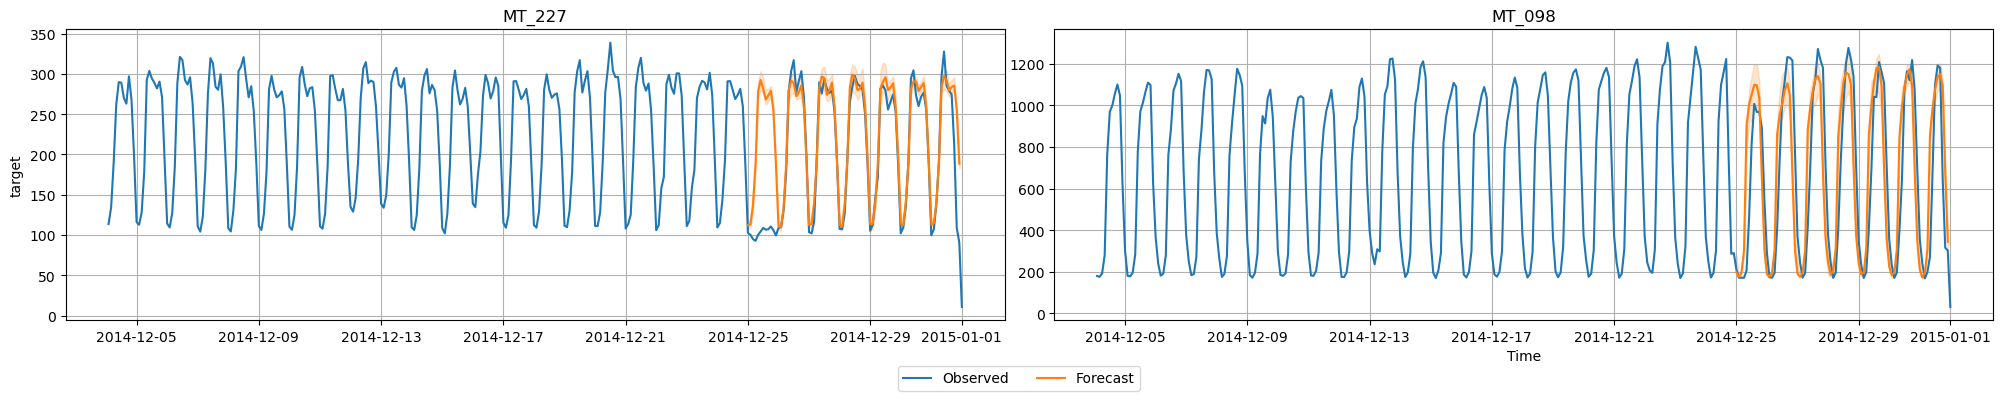

In [259]:
n_windows = 4
splitter = ExpandingWindowSplitter(prediction_length=prediction_length, num_val_windows=n_windows)
item_ids = test_df.item_ids[:2]
scores = []

for window_idx, (train_split, val_split) in enumerate(splitter.split(test_df.slice_by_timestep(end_index=-1))):
    # predict
    split_prediction_df = chronos_predictor.predict(data=val_split.slice_by_timestep(end_index=-prediction_length), model=model)
    # visualize
    chronos_predictor.plot(
        data=test_df.slice_by_timestep(start_index=-n_windows*prediction_length),
        predictions=split_prediction_df,
        item_ids=item_ids,
    )
    # evaluate
    score = chronos_predictor.evaluate(
        data=val_split,
        metrics=metrics,
        model=model,
    )
    
    print(f"Window {window_idx}: score = {score}")
    scores.append(score)

#### Save the model performance to a file
Save the scoring from the backtest with multiple windows to a file. The simplest method to calculate an aggregated metric for backtest with multiple windows is to take the arithmetic mean across all windows. This gives equal weight to each window. You can also use the median metric value across windows that can be more robust to outliers.

In [246]:
display_and_save_metrics(
    model_metrics=pd.DataFrame(data=scores).mean().to_dict(), 
    experiment_name=f"{chronos_experiment_name}-bt-{n_windows}", 
    timestamp=strftime("%Y%m%d-%H%M%S", gmtime())
)

         timestamp metric_name      value  \
0  20240914-144426         WQL   0.087675   
1  20240914-144426        MAPE   0.125366   
2  20240914-144426        WAPE   0.105858   
3  20240914-144426        RMSE  82.325740   
4  20240914-144426        MASE   1.724942   

                                experiment  
0  autogluon-Chronos[base]-2H-2-17533-bt-4  
1  autogluon-Chronos[base]-2H-2-17533-bt-4  
2  autogluon-Chronos[base]-2H-2-17533-bt-4  
3  autogluon-Chronos[base]-2H-2-17533-bt-4  
4  autogluon-Chronos[base]-2H-2-17533-bt-4  


,timestamp,metric_name,value,experiment
0,20240914-144426,WQL,0.087675,autogluon-Chronos[base]-2H-2-17533-bt-4
1,20240914-144426,MAPE,0.125366,autogluon-Chronos[base]-2H-2-17533-bt-4
2,20240914-144426,WAPE,0.105858,autogluon-Chronos[base]-2H-2-17533-bt-4
3,20240914-144426,RMSE,82.325740,autogluon-Chronos[base]-2H-2-17533-bt-4
4,20240914-144426,MASE,1.724942,autogluon-Chronos[base]-2H-2-17533-bt-4


### Optional: configuring for performance

As with all large deep learning models some fine-grained control of inference parameters can be needed to both optimize the speed and avoid out-of-memory issues on specific hardware. For this, we will need to dive a bit deeper, configuring `hyperparameters` of the `TimeSeriesPredictor` directly.

In [247]:
chronos_cpu_predictor = TimeSeriesPredictor(prediction_length=prediction_length).fit(
    train_df,
    hyperparameters={
        "Chronos": {
            "model_path": "mini",
            "batch_size": 64,
            "device": "cpu"
        }
    },
    skip_model_selection=True,
    verbosity=0,
)

In [248]:
%%time
predictions = chronos_cpu_predictor.predict(test_df)

config.json:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/81.8M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

CPU times: user 1min, sys: 17 s, total: 1min 17s
Wall time: 10.9 s


You used the following configuration options for the `TimeSeriesPredictor`:
- `skip_model_selection=True` to skip running backtests during `fit`, as you use a single model only.
- in the `hyperparameters` for the Chronos model,
    - `model_path` allows to change the model size or select different pretrained weights. This parameter can be a model string like `tiny` or `base`, a Hugging Face path like `amazon/chronos-t5-mini`, or a path to a local folder with custom weights.
    - `batch_size` configures the number of time series for which predictions are generated in parallel.
    - `device` instructs Chronos to run the model on CPU.

If you run this notebook on a GPU-instances, you see that inference speed is slower on the CPU. To improve inference speed AutoGluon implementation of Chronos supports several deep learning compilers that can optimize model performance on CPUs.

For example, you can set `optimization_strategy="openvino"` to use the [OpenVINO](https://github.com/openvinotoolkit/openvino) compiler for Intel CPUs to speed up Chronos inference. Behind the scenes, AutoGluon will use Hugging Face [optimum](https://github.com/huggingface/optimum-intel) for this conversion.

Note that this requires installing the optional OpenVINO dependency for AutoGluon Time Series.

In [249]:
!pip install -q "autogluon.timeseries[chronos-openvino]"

To speed up the inference even further, we can `persist` the model after calling `fit`. The `TimeSeriesPredictor.persist()` method tells AutoGluon to keep the Chronos model in device memory for fast, on-demand inference instead of loading the model from disk each time.

In [250]:
%%capture
fast_chronos_cpu_predictor = TimeSeriesPredictor(prediction_length=prediction_length).fit(
    train_df,
    hyperparameters={
        "Chronos": {
            "model_path": "tiny",
            "batch_size": 64,
            "device": "cpu",
            "optimization_strategy": "openvino",
        }
    },
    skip_model_selection=True,
    verbosity=0,
)
predictor.persist()

In [251]:
%%time
predictions = fast_chronos_cpu_predictor.predict(test_df)

config.json:   0%|          | 0.00/1.14k [00:00<?, ?B/s]

INFO:nncf:NNCF initialized successfully. Supported frameworks detected: torch, tensorflow, onnx, openvino


INFO:datasets:PyTorch version 2.3.1 available.
INFO:datasets:TensorFlow version 2.14.0 available.


model.safetensors:   0%|          | 0.00/33.6M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

CPU times: user 31.3 s, sys: 1.8 s, total: 33.1 s
Wall time: 12.1 s


Depending on your environment and the used JupyterLab App instance you might see an increase in inference time.

You can also use the ONNX runtime by providing `optimization_strategy="onnx"`. For a discussion of these and other hyperparameters of Chronos, see the Chronos model [documentation](forecasting-model-zoo.md).

### Further Chronos experiments

You can use another Chronos-specific presets as described in the [`TimeSeriesPredictor.fit()`](https://auto.gluon.ai/stable/api/autogluon.timeseries.TimeSeriesPredictor.fit.html) documentation:
- `chronos_ensemble`: builds an ensemble of seasonal naive, tree-based and deep learning models with fast inference and `chronos_small`.    
- `chronos_large_ensemble`: builds an ensemble of seasonal naive, tree-based and deep learning models with fast inference and `chronos_large`.

Feel free to experiment with these presets using code from this notebook.

<div class="alert alert-info">Note you can use these presets to fit models and run inference on GPU instances only.</div>

---

## Clean up

In [252]:
# free memory
predictor.unpersist()

['PatchTST',
 'DirectTabular',
 'TemporalFusionTransformer',
 'Chronos[base]',
 'NPTS',
 'WeightedEnsemble']

## Shutdown kernel

In [253]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>